# Code to create violin plots for HRApop validations 

## Import statements

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import ttest_ind, ttest_ind_from_stats

import importlib
importlib.reload(pd)

<module 'pandas' from 'C:\\Users\\abueckle\\AppData\\Roaming\\Python\\Python311\\site-packages\\pandas\\__init__.py'>

## Global variables

In [13]:
hra_pop_version = "0.10.2"

## Import data

In [14]:
with open(f"../../../hra-pop/output-data/v{hra_pop_version}/reports/atlas/validation-v2p1.csv", 'r') as file:
	validation_data = pd.read_csv(file)
 
print(validation_data.head())

    sex                                             sample  \
0  Male  https://api.cellxgene.cziscience.com/dp/v1/col...   
1  Male  https://api.cellxgene.cziscience.com/dp/v1/col...   
2  Male  https://api.cellxgene.cziscience.com/dp/v1/col...   
3  Male  https://api.cellxgene.cziscience.com/dp/v1/col...   
4  Male  https://api.cellxgene.cziscience.com/dp/v1/col...   

                                             dataset     tool  \
0  https://api.cellxgene.cziscience.com/dp/v1/col...  azimuth   
1  https://api.cellxgene.cziscience.com/dp/v1/col...  azimuth   
2  https://api.cellxgene.cziscience.com/dp/v1/col...     popv   
3  https://api.cellxgene.cziscience.com/dp/v1/col...     popv   
4  https://api.cellxgene.cziscience.com/dp/v1/col...     popv   

             modality               organ         organId         as_label  \
0  sc_transcriptomics  respiratory system  UBERON:0001004  right ventricle   
1  sc_transcriptomics  respiratory system  UBERON:0001004  right ventricle   
2 

## Transform data 

### Create look-up from AS to organ

In [15]:
organ_look_up = {
    'left ureter': "ureter",
    'cecum': "large intestine",
    'papilla': "kidney",
    'descending colon': "large intestine",
    'rectum': "large intestine",
    'ileum': "small intestine",
    'ascending colon': "large intestine",
    'skin of body': "skin",
    'skin':'skin',
    'outer cortex of kidney': "kidney",
    'left atrium': "heart",
    'right ventricle': "heart",
    'ascending duodenum': "small intestine",
    'jejunum': "small intestine",
    'septum': "heart",
    'renal column (column of bertin)': "kidney",
    'transverse colon': "large intestine",
    'hilum': "spleen",
    'inferior duodenum': "small intestine",
    'left ventricle': "heart",
    'kidney capsule': "kidney",
    'descending duodenum': "small intestine",
    'renal pyramid': "kidney",
    'fundus of urinary bladder': "urinary bladder",
    'right atrium': "heart",
    'terminal ileum': "small intestine",
    'sigmoid colon': "large intestine",
    'renal papilla': "kidney"
}

validation_data['organ_as_label'] = validation_data['as_label'].map(organ_look_up) + \
    " - " + validation_data['as_label']

### Unify skin and skin of body
The `as_label` column in the source data lists `skin` and `skin of body`, so we need to unify those to avoid showing skin twice. This is captured in this [GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/77).

In [16]:
validation_data['as_label'] = validation_data['as_label'].replace('skin of body', 'skin')

## Functions for formatting and plotting

In [17]:
# Define a function to format tick labels
def format_ticks(x):
    """
    Takes a number and returns it with one decimal

    Args:
    x (float): a number

    Returns:
    float: the number with one decimal
    """
    return "{:.1f}".format(x)


def plot(tool):
    """
    Creates a violin plot for one tool only

    Args:
    tool (string): a cell type annotation tool
    """
    for_plot = validation_data[
        (validation_data.as_tool == tool) & (validation_data.tool == tool)
    ]
    
    # Change colors
    custom_palette = ["#EF5350", "#66BB6A"]
    
    # add violin plot
    violin = sns.violinplot(
        data=for_plot,
        x="organ_as_label",
        y="similarity",
        density_norm="width",
        cut=0,
        linewidth=0.2,
        palette=custom_palette,
        # inner="box",
        hue="as_in_collisions",
        split=True,
        order=sorted(for_plot['organ_as_label'].unique())
    )
    
    # add box plot
    box = sns.boxplot(
        x="organ_as_label", 
        y="similarity",
        linewidth=.5,
        showfliers = False,
        color="#BDBDBD",
        data=for_plot, 
        width=0.15
        )

    # add strip plot with jitter
    sns.stripplot(
        data=for_plot,
        x="organ_as_label",
        y="similarity",
        jitter=True,
        palette=custom_palette,
        dodge=True,
        size=2.5,
        hue="as_in_collisions",
        linewidth=.1,
        edgecolor="black",
        order=sorted(for_plot['organ_as_label'].unique())
    )

    set_theme(violin=violin, tool=tool)


def set_theme(violin, tool):
    """
    Takes a plot and adds a theme

    Args:
    violin (sns plot): a violin plot
    """
    violin = violin

    plt.xticks(rotation=60)
    sns.set_theme(rc={"figure.figsize": (8.125, 2.5)})

    #  change the axis labels
    violin.set_xlabel("Anatomical Structure", fontsize=8)
    violin.set_ylabel("Weighted Cosine Similarity", fontsize=8)

    # set font
    sns.set(font='Arial')

    # get the Axes object of the current plot
    ax = plt.gca()

    # Change the size of the x-axis tick labels
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    plt.legend(
        title="Does dataset actually collide with\n anatomical structure?", loc="best"
    )
    plt.setp(ax.get_legend().get_texts(), fontsize="8")  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize="8")  # for legend title
    
    save_as_pdf(ax.figure, tool)

def save_as_pdf(figure, tool):
    """Saves plot as PDF
    """
    
    figure.savefig(f"output/plot_{tool}.pdf", format='pdf')

def report_numbers(as_label, tool, as_in_collisions):
    """Prints the number of datasets analyzed for all anatomical structures with one tool and given whether the dataset actually does collide with the AS

    Args:
        as_label (string ): AS label
        tool (string): CTAnn tool
    """
    print(
        f"For {len(validation_data[(validation_data.as_label == as_label) & (validation_data.as_tool == tool) & (validation_data.tool == tool) & (validation_data.as_in_collisions == as_in_collisions)].dataset.unique())} out of {len(validation_data[(validation_data.as_label == as_label) & (validation_data.as_tool == tool) & (validation_data.tool == tool) ])} datasets " +
        f"annotated through {tool} for {as_label}, does the extraction site of the dataset actually does collide with {as_label}? {as_in_collisions}."
    )

def get_mean_cosine_similarity_per_tool(tool:str):
    """Get the mean cosine similarity by tool and AS

    Args:
        tool (str): a CTann tool
    
    Returns:
        cosine_similarities: a list of cosine similarities for a tool
    """
    tool_only = validation_data[
        (validation_data.as_tool == tool) & (validation_data.tool == tool)
    ]
    
    similarities = tool_only['similarity']
    
    return similarities

def get_unique_as_in_data(tool):
    """Get a list of all AS and organs for which we have tool comparisons

    Args:
        tool (string): a CTAnn tool

    Returns:
        list: a list of strings
    """
    for_plot = validation_data[
        (validation_data.as_tool == tool) & (validation_data.tool == tool)
    ]

    # make new column with combomof as_label and organ
    return list(for_plot.organ_as_label.unique())

## Report numbers

In [18]:
# Total numbers
as_label = "right atrium"
datasets_for_right_atrium = validation_data[validation_data.as_label == as_label]
print(
    f"The total number of datasets in the {as_label} is: {len(datasets_for_right_atrium.dataset.unique())}"
)

# Unique AS per organ
tools = ("azimuth", "celltypist", "popv")
unique_as = set()

for tool in tools:
    for as_label in get_unique_as_in_data(tool):
        unique_as.add(as_label)

print(f"Found {len(unique_as)} unique AS across 3 plots: {unique_as}")

The total number of datasets in the right atrium is: 193
Found 28 unique AS across 3 plots: {'spleen - hilum', 'heart - left ventricle', 'skin - skin of body', 'kidney - renal papilla', 'kidney - kidney capsule', 'large intestine - sigmoid colon', 'heart - left atrium', 'heart - septum', 'kidney - renal pyramid', 'kidney - papilla', 'small intestine - descending duodenum', 'large intestine - cecum', 'heart - right ventricle', 'large intestine - descending colon', 'small intestine - inferior duodenum', 'small intestine - ileum', 'large intestine - rectum', 'small intestine - ascending duodenum', 'skin - skin', 'kidney - renal column (column of bertin)', 'large intestine - ascending colon', 'heart - right atrium', 'small intestine - jejunum', 'small intestine - terminal ileum', 'kidney - outer cortex of kidney', 'urinary bladder - fundus of urinary bladder', 'ureter - left ureter', 'large intestine - transverse colon'}


### Median and mean cosine similarity

In [19]:
print(f"Mean across all similarities: {validation_data['similarity'].mean()}")
print(
    f"Median across all similarities: {validation_data['similarity'].median()}")

Mean across all similarities: 0.5290947564779361
Median across all similarities: 0.4996236928980191


### Azimuth

For 16 out of 139 datasets annotated through azimuth for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 123 out of 139 datasets annotated through azimuth for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


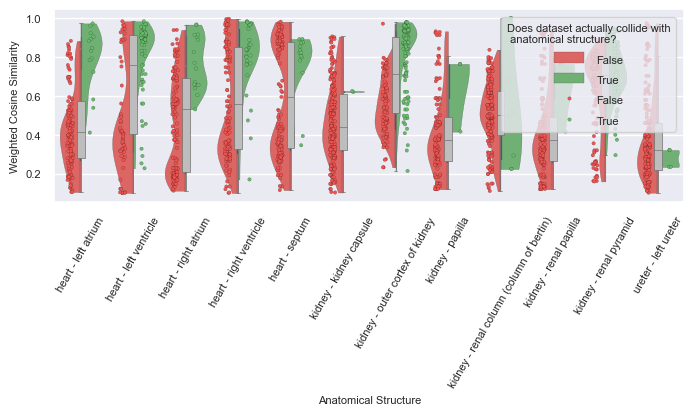

In [20]:
tool = "azimuth"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)

### CellTypist

For 16 out of 117 datasets annotated through celltypist for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 101 out of 117 datasets annotated through celltypist for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


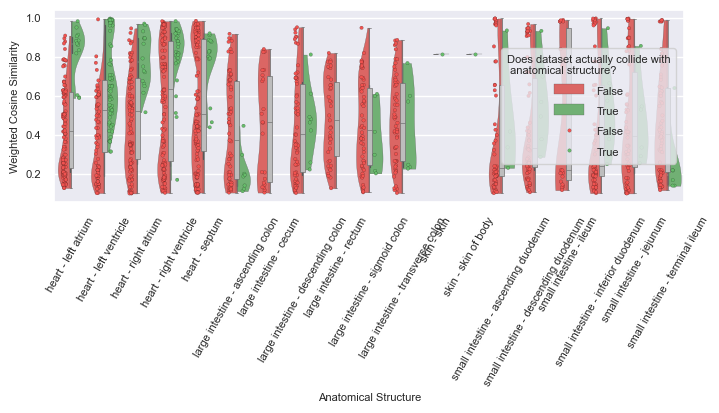

In [21]:
tool = "celltypist"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)

### popV

For 16 out of 129 datasets annotated through popv for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 113 out of 129 datasets annotated through popv for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


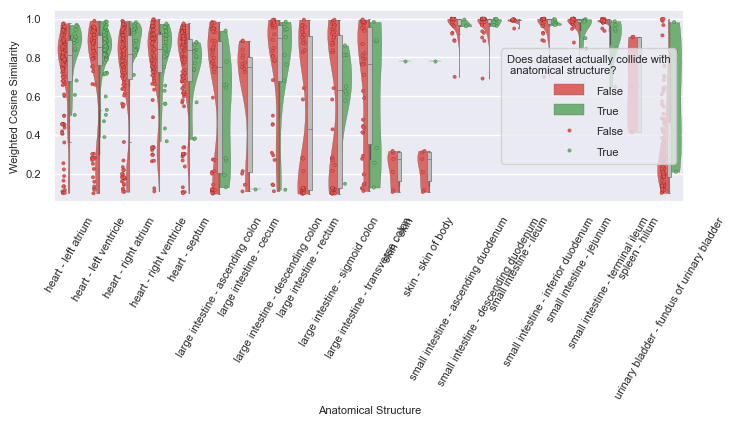

In [22]:
tool = "popv"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)